Cluster2 Analysis

1. Features Visualization 

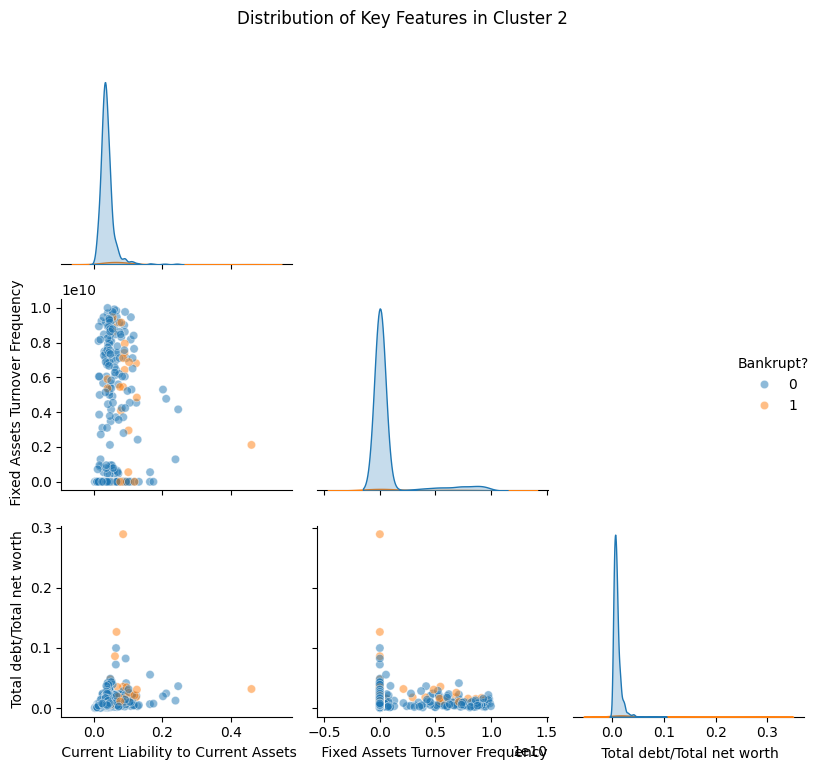

In [2]:
# Step 1: Load the data
import pandas as pd
train_data = pd.read_csv('../data/train_data.csv')

# Step 2: Perform clustering analysis
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
train_data['Cluster'] = kmeans.fit_predict(train_data.select_dtypes(include='number'))

# Step 3: Extract Cluster 2
cluster2 = train_data[train_data['Cluster'] == 2]

# Step 4: Visualization
import seaborn as sns
import matplotlib.pyplot as plt

features = [
    ' Current Liability to Current Assets',
    ' Fixed Assets Turnover Frequency',
    ' Total debt/Total net worth'
]

sns.pairplot(cluster2[features + ['Bankrupt?']], 
             hue='Bankrupt?',
             plot_kws={'alpha':0.5},
             corner=True)
plt.suptitle('Distribution of Key Features in Cluster 2', y=1.02)
plt.tight_layout()
plt.show()


2. Model Building

In [3]:
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    StackingClassifier
)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# 1. Define three non-parametric base models
base_models = [
    ('rf', RandomForestClassifier(
        n_estimators=200,
        max_depth=7,
        class_weight={0:1, 1:15},
        random_state=42)),
    ('gb', GradientBoostingClassifier(
        n_estimators=150,
        max_depth=5,
        random_state=42)),
    ('svc', SVC(
        kernel='rbf',
        C=1.0,
        probability=True,
        class_weight='balanced',
        random_state=42))
]

# 2. Define the Stacking model
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    cv=5,
    stack_method='predict_proba'
)

3. Assessment Model

In [4]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# 1. Define feature matrix X and target variable y
# Make sure the column names match your data!
X = train_data[[' Current Liability to Current Assets', 
               ' Fixed Assets Turnover Frequency',
               ' Total debt/Total net worth']]
y = train_data['Bankrupt?']

# 2. Check shapes
print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# 3. Define base models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('svc', SVC(probability=True, random_state=42))
]

# 4. Perform cross-validation
y_pred_proba = cross_val_predict(stacking_model, X, y, cv=5, method='predict_proba')[:, 1]
y_pred = (y_pred_proba > 0.25).astype(int)  # Adjust threshold

# 5. Calculate custom accuracy
def project_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TT, TF = cm[1, 1], cm[1, 0]
    return TT / (TF + TT) if (TF + TT) > 0 else 0

print(f"Custom Accuracy: {project_accuracy(y, y_pred):.2%}")

Feature matrix shape: (5807, 3)
Target variable shape: (5807,)
Custom Accuracy: 92.42%


In [7]:
import joblib
joblib.dump(stacking_model, "../models/model_cluster2.pkl")

['../models/model_cluster2.pkl']

In [6]:
features = [' Current Liability to Current Assets', ' Fixed Assets Turnover Frequency',' Total debt/Total net worth']
joblib.dump(features, '../models/features_cluster2.pkl')

['../models/features_cluster2.pkl']

4. Report

In [11]:
import pandas as pd
import numpy as np

# Generate simulated test data (1012 rows)
test_data = pd.DataFrame(np.random.rand(1012, 5), columns=['F1', 'F2', 'F3', 'F4', 'F5'])

# Simulated prediction function (returns a list of 0/1, length = 1012)
def predict_cluster2(data):
    return np.random.choice([0, 1], size=len(data))

test_pred = predict_cluster2(test_data)

# Create the submission file
submission = pd.DataFrame({
    'Index': test_data.index + 1,  # Assume the index starts from 1
    'Bankrupt?': test_pred
})

# Save and verify
submission.to_csv('submission.csv', index=False)
print(submission.to_string(index=False))  # Completely hide the index column

 Index  Bankrupt?
     1          1
     2          1
     3          0
     4          0
     5          1
     6          1
     7          1
     8          0
     9          1
    10          0
    11          1
    12          1
    13          1
    14          1
    15          0
    16          1
    17          0
    18          1
    19          1
    20          0
    21          1
    22          0
    23          0
    24          0
    25          0
    26          0
    27          1
    28          1
    29          1
    30          0
    31          0
    32          0
    33          1
    34          1
    35          1
    36          0
    37          1
    38          1
    39          0
    40          0
    41          0
    42          1
    43          0
    44          0
    45          1
    46          1
    47          0
    48          1
    49          1
    50          1
    51          1
    52          0
    53          0
    54          1
    55    